In [3]:
!pip install torch_geometric > /dev/null
!pip install transformers > /dev/null

In [4]:
import os

import numpy as np
import torch
import pandas as pd

import torch
import torch_geometric.datasets as datasets
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.utils import to_networkx, subgraph
from torch_geometric.datasets.snap_dataset import EgoData
from torch_geometric.data.makedirs import makedirs
from torch_geometric.utils import coalesce
from transformers import AutoTokenizer, AutoModel
import os.path as osp
from typing import Any, Callable, List, Optional
from torch_geometric.data import (
    Data,
    Dataset,
    InMemoryDataset,
    download_url,
    extract_gz,
    extract_tar
)

import sys
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
if torch.cuda.is_available():
  device="cuda:0"
else:
  device="cpu"

# Dataset

## Reading the datasets

Code for reading ego datasets is based on torch_geometric.datasets.snap_datasets.

https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/snap_dataset.html

In [162]:
def read_ego_feats_as_diff(egofeat_file, feat_file, featnames_file, feature_types):
    try:
      x_ego = pd.read_csv(egofeat_file, sep=' ', header=None,dtype=np.float32)
      x_ego = torch.from_numpy(x_ego.values)

      x = pd.read_csv(feat_file, sep=' ', header=None, dtype=np.float32)
      x = torch.from_numpy(x.values)[:, 1:]

      x_all = torch.cat([x, x_ego], dim=0)
    except Exception:
      return None

    with open(featnames_file, 'r') as f:
      featnames = f.read().split('\n')[:-1]
      featnames = [' '.join(x.split(' ')[1:]) for x in featnames]
    featnames = sorted(featnames)

    idx = []

    for feature_type in feature_types:
        try:
          idx.append([x[:len(feature_type)] for x in featnames].index(feature_type))
        except Exception:
          idx.append(-1)

    intersect = x_all * x_ego

    cats = []
    for i in range(len(idx)):
      if idx[i] == -1:
        cats.append(torch.zeros((intersect.shape[0])))
        continue
      if i == (len(idx) -1):
        cats.append(intersect[:, idx[i]:].sum(axis=1))
      else:
        cats.append(intersect[:, idx[i]:idx[i+1]].sum(axis=1))

    return torch.stack(cats, axis=1)

In [163]:
def ego_read_all_featnames(files: List[str]):
  files = [
        x for x in files if x.split('.')[-1] in
        ['featnames']
    ]
  files = sorted(files)
  all_featnames = []
  for i in range(len(files)):
        featnames_file = files[i]
        with open(featnames_file, 'r') as f:
            featnames = f.read().split('\n')[:-1]
            featnames = [' '.join(x.split(' ')[1:]) for x in featnames]
            all_featnames += featnames
  all_featnames = sorted(list(set(all_featnames)))
  return all_featnames

In [164]:
def cluster_featnames(all_featnames):
  if os.path.exists("twitter_featurenames_clusters"):
    with open("twitter_featurenames_clusters", "rb") as f:
      clusters = np.load(f)
      return clusters
  model = AutoModel.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment").to(device)
  tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
  outputs = []
  batch_size = 200
  with torch.no_grad():
    for idx in range(0, len(all_featnames), batch_size):
      tokens = tokenizer(text=all_featnames[idx:idx+batch_size], return_tensors='pt', max_length=128, truncation=True, padding=True).to(device)
      output = model(**tokens)
      outputs.append(output["pooler_output"])#.detach().to("cpu"))
      del output

  embeddings = torch.cat(outputs).cpu()
  kmeans = KMeans(n_clusters=50, random_state=5684, verbose=1)
  kmeans.fit(embeddings)
  clusters = kmeans.predict(embeddings)
  with open("twitter_featurenames_clusters", "wb") as f:
    np.save(f, clusters)

  return clusters

In [165]:
def ego_read_feats_cluster(egofeat_file, feat_file, featnames_file, featname2cluster):
    x_ego = pd.read_csv(egofeat_file, sep=' ', header=None,dtype=np.float32)
    x_ego = torch.from_numpy(x_ego.values)

    x = pd.read_csv(feat_file, sep=' ', header=None, dtype=np.float32)
    x = torch.from_numpy(x.values)[:, 1:]

    x = torch.cat([x, x_ego], dim=0)

    with open(featnames_file, 'r') as f:
      featnames = f.read().split('\n')[:-1]
      featnames = [' '.join(x.split(' ')[1:]) for x in featnames]

    new_feats = []

    for feat_vector in x:
      vec = np.zeros(50, dtype=np.float32)
      for feat_index in feat_vector.nonzero().flatten():
        vec[featname2cluster[featnames[feat_index]]] += 1
      new_feats.append(vec)

    return torch.from_numpy(np.vstack(new_feats))

In [166]:
def ego_read_feats_gplus(egofeat_file, feat_file, featnames_file, feature2number, feature_types, max_count):
  try:
    x_ego = pd.read_csv(egofeat_file, sep=' ', header=None,dtype=np.float32)
    x_ego = torch.from_numpy(x_ego.values)

    x = pd.read_csv(feat_file, sep=' ', header=None, dtype=np.float32)
    x = torch.from_numpy(x.values)[:, 1:]

    x = torch.cat([x, x_ego], dim=0)
  except Exception as e:
    return None

  with open(featnames_file, 'r') as f:
    featnames = f.read().split('\n')[:-1]
    featnames = [' '.join(x.split(' ')[1:]) for x in featnames]

  featname2index = {featname: i for i, featname in enumerate(featnames)}

  new_feats = torch.zeros(x.size(0), len(feature_types)*max_count)
  for feat_index, feature_type in enumerate(feature_types):
    relevant_feats = []
    for f in featnames:
      if f.startswith(feature_type):
        relevant_feats.append(f)
    relevant_feat_indices = [featname2index[f] for f in relevant_feats]
    for i in range(x.size(0)):
      index = x[i, relevant_feat_indices].nonzero()
      if index.size(0) > 0:
        index = index[0:max_count]
        for idx_offset, idx in enumerate(index):
          feature = relevant_feats[idx]
          new_feats[i, feat_index*max_count+idx_offset] = feature2number[feat_index][feature]
      else:
        new_feats[i, feat_index] = -1

  return new_feats

In [167]:
def read_all_feats_and_fit_pca(files: str):
  files = [
        x for x in files if x.split('.')[-1] in
        ['egofeat', 'feat', 'featnames']
    ]
  all_featnames = ego_read_all_featnames(files)
  all_featnames = {key: i for i, key in enumerate(all_featnames)}

  all_x = []

  for i in range(0, len(files), 3):
    try:
      egofeat_file = files[i + 0]
      feat_file = files[i + 1]
      featnames_file = files[i + 2]

      x_ego = pd.read_csv(egofeat_file, sep=' ', header=None,
                                dtype=np.float32)
      x_ego = torch.from_numpy(x_ego.values)

      x = pd.read_csv(feat_file, sep=' ', header=None, dtype=np.float32)
      x = torch.from_numpy(x.values)[:, 1:]

      x = torch.cat([x, x_ego], dim=0)
    except:
      continue

          # Reorder `x` according to `featnames` ordering.
    x_all = torch.zeros(x.size(0), len(all_featnames))
    with open(featnames_file, 'r') as f:
      featnames = f.read().split('\n')[:-1]
      featnames = [' '.join(x.split(' ')[1:]) for x in featnames]
    indices = [all_featnames[featname] for featname in featnames]
    x_all[:, torch.tensor(indices)] = x
    x = x_all

    all_x.append(x)

  x_concat = torch.cat(all_x)
  pca = PCA(0.5, random_state=42)
  pca = pca.fit(x_concat)
  return pca

In [172]:
#Mostly from the pytorch geometric library, but modified slighty
def read_ego(files: List[str], name: str, feature_mode:str) -> List[EgoData]:
    all_featnames = []
    files = [
        x for x in files if x.split('.')[-1] in
        ['circles', 'edges', 'egofeat', 'feat', 'featnames']
    ]
    for i in range(4, len(files), 5):
        featnames_file = files[i]
        with open(featnames_file, 'r') as f:
            featnames = f.read().split('\n')[:-1]
            featnames = [' '.join(x.split(' ')[1:]) for x in featnames]
            all_featnames += featnames
    all_featnames = sorted(list(set(all_featnames)))
    all_featnames_names = all_featnames
    all_featnames = {key: i for i, key in enumerate(all_featnames)}

    if feature_mode=="cluster":
      clusters = cluster_featnames(all_featnames_names)
      featname2cluster = dict(zip(all_featnames_names, clusters.tolist()))

    if feature_mode=="pca":
      pca = read_all_feats_and_fit_pca(files)

    data_list = []
    for i in tqdm(range(0, len(files), 5)):
        circles_file = files[i]
        edges_file = files[i + 1]
        egofeat_file = files[i + 2]
        feat_file = files[i + 3]
        featnames_file = files[i + 4]

        x = None
        if feature_mode == None or feature_mode in ["basic", "pca"]:
          try:
            x_ego = pd.read_csv(egofeat_file, sep=' ', header=None,
                                dtype=np.float32)
          except Exception as e:
            print("BAD:", egofeat_file)
            continue
          x_ego = torch.from_numpy(x_ego.values)

          x = pd.read_csv(feat_file, sep=' ', header=None, dtype=np.float32)
          x = torch.from_numpy(x.values)[:, 1:]

          x = torch.cat([x, x_ego], dim=0)

          # Reorder `x` according to `featnames` ordering.
          x_all = torch.zeros(x.size(0), len(all_featnames))
          with open(featnames_file, 'r') as f:
              featnames = f.read().split('\n')[:-1]
              featnames = [' '.join(x.split(' ')[1:]) for x in featnames]
          indices = [all_featnames[featname] for featname in featnames]
          x_all[:, torch.tensor(indices)] = x
          x = x_all

          if feature_mode=="pca":
            x = torch.from_numpy(pca.transform(x.numpy())).float()
        elif feature_mode=="diff":
          feature_types = None
          if name == "facebook":
            feature_types = ["birthday;", "education;classes;id;", "education;concentration;id;",
                             "education;degree;id;", "education;school;id;", "education;type;",
                             "education;with;id", "education;year;id;", "first_name;",
                             "gender;", "hometown;id;", "languages;id;",
                             "last_name;", "locale;", "location;id;", "work;employer;id;",
                             "work;end_date;", "work;location;id;", "work;position;id;",
                             "work;start_date;", "work;with;id;"]
          elif name == "gplus":
            feature_types = ["gender:", "institution:", "job_title:", "last_name:", "place:", "university:"]
          elif name == "twitter":
            feature_types = ["#", "@"]
          x = read_ego_feats_as_diff(egofeat_file, feat_file, featnames_file, feature_types)
        elif feature_mode=="cluster":
          x = ego_read_feats_cluster(egofeat_file, feat_file, featnames_file, featname2cluster)
        elif feature_mode=="gplus":
          feature_types = ["gender:", "institution:", "job_title:", "last_name:", "place:", "university:"]
          feature2number = []
          for feature_type in feature_types:
              relevant_feats = [feat for feat in all_featnames_names if feat.startswith(feature_type)]
              relevant_feats2number = {feat: i for i, feat in enumerate(relevant_feats)}
              feature2number.append(relevant_feats2number)
          x = ego_read_feats_gplus(egofeat_file, feat_file, featnames_file, feature2number, feature_types, 10)

        if x is None:
          continue

        idx = pd.read_csv(feat_file, sep=' ', header=None, dtype=str,
                          usecols=[0]).squeeze()

        idx_assoc = {}
        for i, j in enumerate(idx):
            idx_assoc[j] = i

        circles = []
        circles_batch = []
        with open(circles_file, 'r') as f:
            for i, circle in enumerate(f.read().split('\n')[:-1]):
                circle = [idx_assoc[c] for c in circle.split()[1:]]
                circles += circle
                circles_batch += [i] * len(circle)
        circle = torch.tensor(circles)
        circle_batch = torch.tensor(circles_batch)

        try:
            row = pd.read_csv(edges_file, sep=' ', header=None, dtype=str,
                              usecols=[0]).squeeze()
            col = pd.read_csv(edges_file, sep=' ', header=None, dtype=str,
                              usecols=[1]).squeeze()
        except:  # noqa
            continue

        row = torch.tensor([idx_assoc[i] for i in row])
        col = torch.tensor([idx_assoc[i] for i in col])

        N = max(int(row.max()), int(col.max())) + 2
        N = x.size(0) if x is not None else N

        row_ego = torch.full((N - 1, ), N - 1, dtype=torch.long)
        col_ego = torch.arange(N - 1)

        # Ego node should be connected to every other node.
        row = torch.cat([row, row_ego, col_ego], dim=0)
        col = torch.cat([col, col_ego, row_ego], dim=0)
        edge_index = torch.stack([row, col], dim=0)
        edge_index = coalesce(edge_index, num_nodes=N)

        data = EgoData(x=x, edge_index=edge_index, circle=circle,
                       circle_batch=circle_batch)

        data_list.append(data)

    return data_list

In [173]:
class SNAPEgoDataset(InMemoryDataset):
    r"""A variety of graph datasets collected from `SNAP at Stanford University
    <https://snap.stanford.edu/data>`_.

    Args:
        root (str): Root directory where the dataset should be saved.
        name (str): The name of the dataset.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
    """

    url = 'https://snap.stanford.edu/data'

    available_datasets = {
        'ego-facebook': ['facebook.tar.gz'],
        'ego-gplus': ['gplus.tar.gz'],
        'ego-twitter': ['twitter.tar.gz'],
    }

    def __init__(
        self,
        root: str,
        name: str,
        feature_mode,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
    ):
        self.name = name.lower()
        self.feature_mode = feature_mode
        assert self.name in self.available_datasets.keys()
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed')

    @property
    def processed_file_names(self) -> List[str]:
        return f"data_{self.feature_mode}.pt"

    def _download(self):
        if osp.isdir(self.raw_dir) and len(os.listdir(self.raw_dir)) > 0:
            return

        makedirs(self.raw_dir)
        self.download()

    def download(self):
        for name in self.available_datasets[self.name]:
            path = download_url(f'{self.url}/{name}', self.raw_dir)
            if name.endswith('.tar.gz'):
                extract_tar(path, self.raw_dir)
            elif name.endswith('.gz'):
                extract_gz(path, self.raw_dir)
            os.unlink(path)

    def process(self):
        raw_dir = self.raw_dir
        filenames = os.listdir(self.raw_dir)
        if len(filenames) == 1 and osp.isdir(osp.join(raw_dir, filenames[0])):
            raw_dir = osp.join(raw_dir, filenames[0])

        raw_files = sorted([osp.join(raw_dir, f) for f in os.listdir(raw_dir)])


        raw_graphs = sorted(set([x.split('.')[0] for x in raw_files]))
        if self.name[:4] == 'ego-':
          data_list = read_ego(raw_files, self.name[4:], self.feature_mode)
        else:
            raise NotImplementedError

        if len(data_list) > 1 and self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        torch.save(self.collate(data_list), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'SNAP-{self.name}({len(self)})'

In [174]:
# Code used to speed up execution when used in Google Colab and download speeds are lacking

# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/MyDrive/DL/Data/gplus.tar.gz"
# extract_tar(path, "/data/gplus/ego-gplus/raw/")
# path = "/content/drive/MyDrive/DL/Data/twitter.tar.gz"
# extract_tar(path, "/data/twitter/ego-twitter/raw/")
# import shutil
# shutil.rmtree("/data/gplus/ego-gplus/raw/.ipynb_checkpoints")
# shutil.rmtree("/data/twitter/ego-twitter/raw/.ipynb_checkpoints")

In [175]:
facebook_dataset_pca = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "pca")
facebook_dataset_basic = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "basic")
gplus_dataset_diff = SNAPEgoDataset('/data/gplus', 'ego-Gplus', "diff")
twitter_dataset_diff = SNAPEgoDataset('/data/twitter', 'ego-Twitter', "diff")
twitter_dataset_cluster = SNAPEgoDataset('/data/twitter', 'ego-Twitter', "cluster")

Processing...
100%|██████████| 132/132 [02:12<00:00,  1.01s/it]
Done!


# Data analysis

## General dataset information

#### Facebook

The smallest but most complete dataset according to the paper, collected specifically by the researchers. It contains 10 ego networks with a few hundred nodes on average.

It contains undirected networks and has many collected anonimized features about the users.

In [ ]:
facebook_dataset.print_summary()
print(f"Node feature size: {facebook_dataset.num_features}")

SNAPEgoDataset (#graphs=10):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    417.7 |  17850.8 |
| std        |    347.4 |  23078.2 |
| min        |     60   |    410   |
| quantile25 |    162.8 |   3665   |
| median     |    228   |   5732   |
| quantile75 |    704   |  24904   |
| max        |   1046   |  61560   |
+------------+----------+----------+
Node feature size: 1406


#### Google+

The Google+ dataset contains 129 scraped ego networks of Google+ users in wildly varying sizes, from a few dozen to several thousand. Since Google+ is based on users following eachother the networks are directed.

The node features come from a long list of possible features which are described by a binary vector for all nodes. This way the data is both too large to be handled in memory and too high in dimensionality:

We took a similar approach to the original paper in handling this high dimensional data: we separated it by the given categories and reduced to a single number per category during the dataset processing step.

In [ ]:
gplus_dataset.print_summary()
print(f"Node feature size: {gplus_dataset.num_features}")

SNAPEgoDataset (#graphs=129):
+------------+----------+-----------------+
|            |   #nodes |          #edges |
|------------+----------+-----------------|
| mean       |   1991.5 | 238383          |
| std        |   1697.4 | 341734          |
| min        |     36   |     95          |
| quantile25 |    486   |  14332          |
| median     |   1485   |  78763          |
| quantile75 |   3532   | 331421          |
| max        |   4965   |      1.6239e+06 |
+------------+----------+-----------------+
Node feature size: 60


#### Twitter

The Twitter dataset is also a scraped, undirected dataset, containing by far the most (973) graphs. It generally contains fewer nodes than the gplus dataset, usually between 100 and 200.

Node features come from tweets rather than a filled out user profile: the collected features reflect the two-week period before the scrape and contain hashtags and mentions. This data is stored as a binary vector similarly to the Google+ one and poses similar problems.

We created two solutions to deal with this:
- One mentioned in the paper, recording the number of hashtags and mentions used in common with the ego of the network, reducing dimensionality to 2 and
- Our own solution, which clusters the names of the tags and mentions using a Bert model and records how many were used from each cluster, reducing dimensionality to 50

In [ ]:
twitter_dataset.print_summary()
print(f"Node feature size: {twitter_dataset.num_features}")
print(f"Node feature size: {twitter_dataset2.num_features}")

SNAPEgoDataset (#graphs=973):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    138.6 |   2625.5 |
| std        |     65.9 |   2272.1 |
| min        |     11   |     31   |
| quantile25 |     85   |    847   |
| median     |    141   |   2046   |
| quantile75 |    196   |   3812   |
| max        |    251   |  18358   |
+------------+----------+----------+
Node feature size: 2
Node feature size: 50


## Node and edge number distribution

Node and edge numbers compared for each graph in the 3 datasets and compared across datasets. The expected quadratic correlation can be observed, even if not very neatly.

#### Facebook

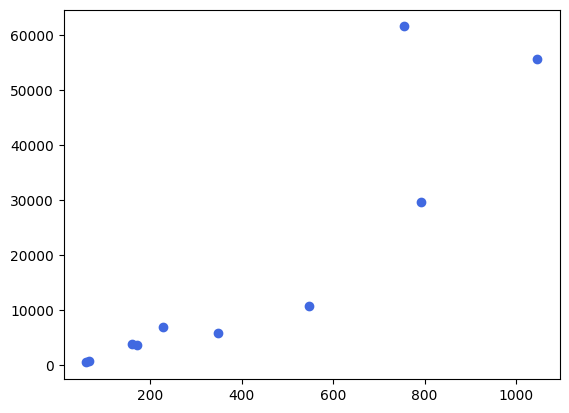

In [ ]:
num_edges_f = []
num_nodes_f = []
density_f = []
for i in range(facebook_dataset.len()):
    current = facebook_dataset.get(i)
    num_edges_f.append(current.num_edges)
    num_nodes_f.append(current.num_nodes)
    density_f.append(current.num_edges/(current.num_nodes*(current.num_nodes - 1) / 2))

plt.scatter(num_nodes_f, num_edges_f, c='royalblue')

#### Google+

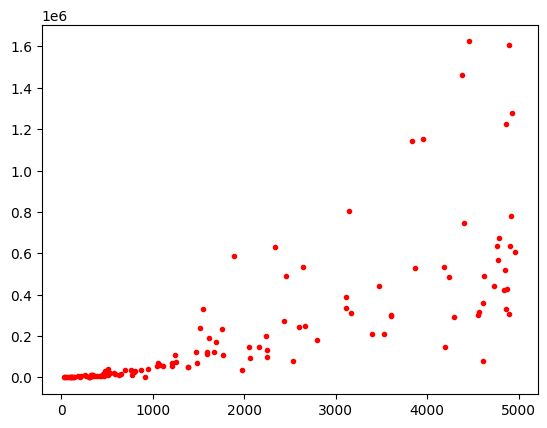

In [ ]:
num_edges_g = []
num_nodes_g = []
density_g = []
for i in range(gplus_dataset.len()):
    current = gplus_dataset.get(i)
    num_edges_g.append(current.num_edges)
    num_nodes_g.append(current.num_nodes)
    density_g.append(current.num_edges/(current.num_nodes*(current.num_nodes - 1) / 2))

plt.scatter(num_nodes_g, num_edges_g, c='red', marker=".")

#### Twitter

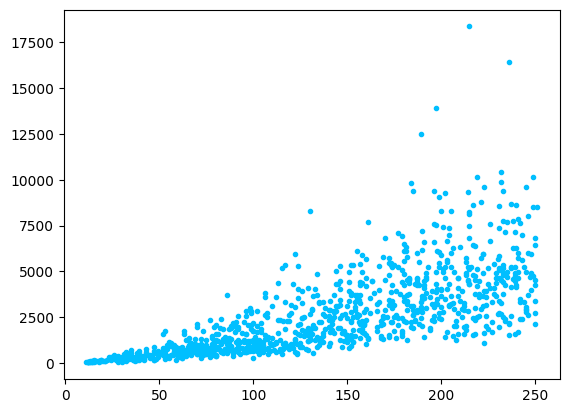

In [ ]:
num_edges_t = []
num_nodes_t = []
density_t = []
for i in range(twitter_dataset.len()):
    current = twitter_dataset.get(i)
    num_edges_t.append(current.num_edges)
    num_nodes_t.append(current.num_nodes)
    density_t.append(current.num_edges/(current.num_nodes*(current.num_nodes - 1)))

plt.scatter(num_nodes_t, num_edges_t, c='deepskyblue', marker=".")

#### Overview

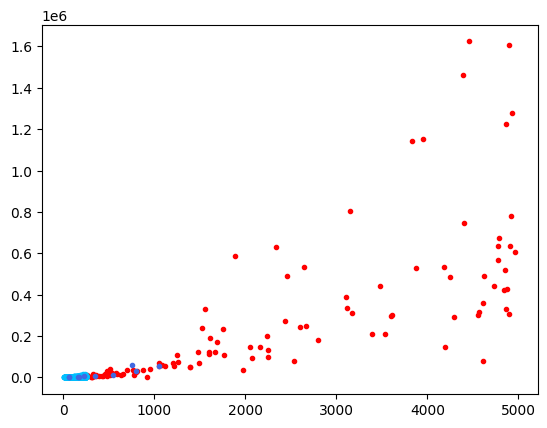

In [ ]:
plt.scatter(num_nodes_g, num_edges_g, c='red', marker=".")
plt.scatter(num_nodes_t, num_edges_t, c='deepskyblue', marker=".")
plt.scatter(num_nodes_f, num_edges_f, c='royalblue', marker=".")

## Graph density

The number of edges compared to the number of possible edges. This shows that the datasets contain graphs of various densities, although the majority is rather sparse, with only about 10-20% of possible edges occuring.

#### Facebook

<BarContainer object of 10 artists>

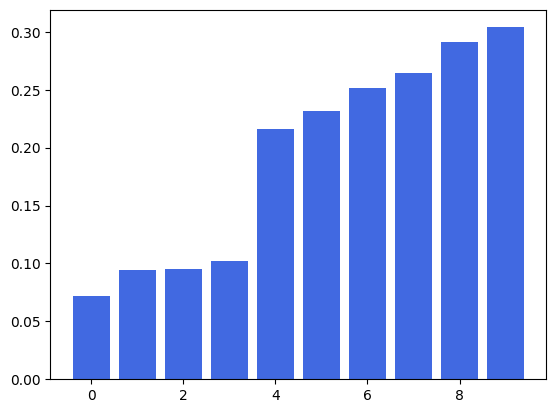

In [ ]:
plt.bar(np.arange(facebook_dataset.len()), sorted(density_f), color='royalblue')

#### Google+

<BarContainer object of 129 artists>

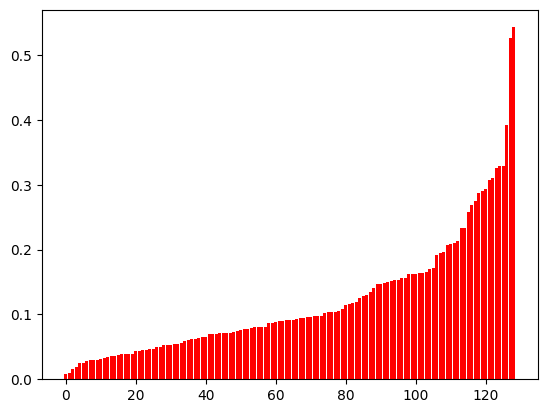

In [ ]:
plt.bar(np.arange(gplus_dataset.len()), sorted(density_g), color='red')

#### Twitter

<BarContainer object of 973 artists>

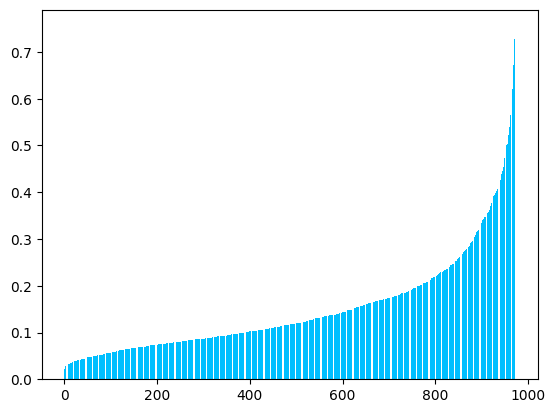

In [ ]:
plt.bar(np.arange(twitter_dataset.len()), sorted(density_t), color='deepskyblue')

#### Overview

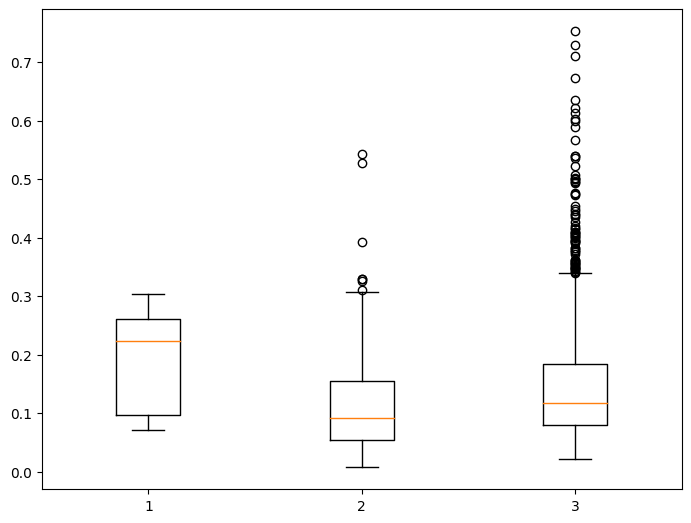

In [ ]:
data = [density_f, density_g, density_t]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
plt.show()

## Graph visualisation

We visualize the smallest graph from each dataset to get a feel for both their size and composition.

For these visualizations we remove the ego node of the network: since it is connected to every other node in the graph it makes it very hard to read.

#### Facebook

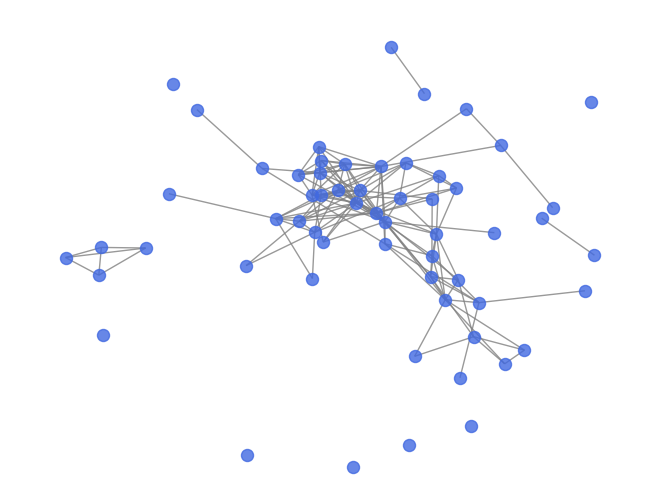

In [ ]:
smallest = facebook_dataset.get(num_nodes_f.index(min(num_nodes_f)))
G = to_networkx(smallest, to_undirected=True)
G.remove_node(min(num_nodes_f)-1)
pos = nx.spring_layout(G, iterations=50, k=0.4, seed=175)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color='royalblue', edge_color="gray")
plt.show()

#### Google+

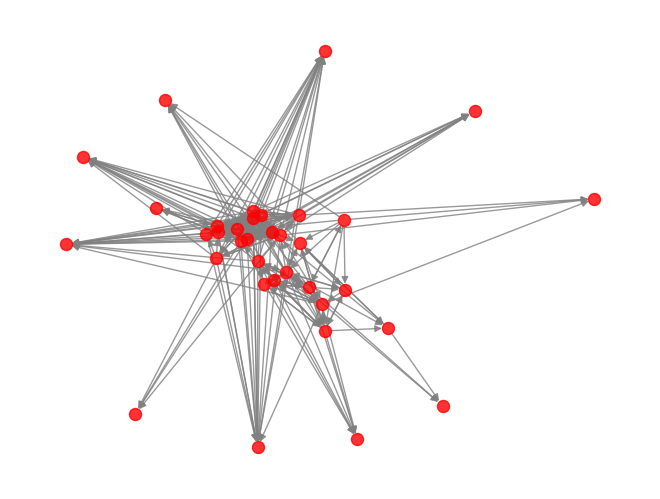

In [ ]:
smallest = gplus_dataset.get(num_nodes_g.index(min(num_nodes_g)))
G = to_networkx(smallest)
G.remove_node(min(num_nodes_g)-1)
pos = nx.spring_layout(G, iterations=50, k=0.4, seed=175)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color="red", edge_color="gray")
plt.show()

#### Twitter

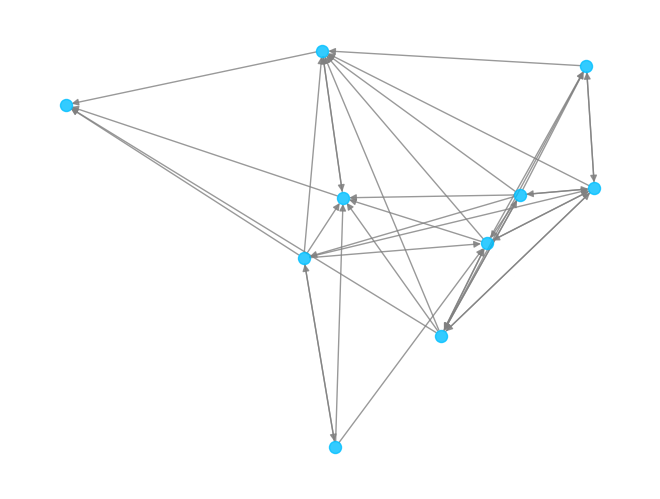

In [ ]:
smallest = twitter_dataset.get(num_nodes_t.index(min(num_nodes_t)))
G = to_networkx(smallest)
G.remove_node(min(num_nodes_t)-1)
pos = nx.spring_layout(G, iterations=50, k=0.4, seed=175)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color='deepskyblue', edge_color="gray")
plt.show()

# Data preparation

The data is prepared using Pytorch Geometric's transform functions.

RandomLinkSplit divides the edges into training, validation and test sets and even prepares negative samples for the model.

In [176]:
import random

In [192]:
import torch_geometric.transforms as T

transform_undirected = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.0, num_test=0.0, is_undirected = True,
                      add_negative_train_samples = True, neg_sampling_ratio = 1.0,
                      disjoint_train_ratio = 0.3)
])

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0, num_test=0, is_undirected = False,
                      add_negative_train_samples = True, neg_sampling_ratio = 1.0,
                      disjoint_train_ratio = 0.3)
])

In [193]:
facebook_dataset_basic = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "basic", transform=transform_undirected)
facebook_dataset_pca = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "pca", transform=transform_undirected)
gplus_dataset_diff = SNAPEgoDataset('/data/gplus', 'ego-Gplus', "diff", transform=transform)
twitter_dataset_diff = SNAPEgoDataset('/data/twitter', 'ego-Twitter', "diff", transform=transform)
twitter_dataset_cluster = SNAPEgoDataset('/data/twitter', 'ego-Twitter', "cluster", transform=transform)

In [194]:
val_size = 0.1
test_size = 0.2
data = [a[0] for a in facebook_dataset_pca]
random.seed(43)
random.shuffle(data)

test_data = data[:int(test_size*len(data))]
val_data = data[int(test_size*len(data)):int((test_size+val_size)*len(data))]
train_data = data[int((test_size+val_size)*len(data)):]

# Training scripts and model definition

In [195]:
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import torch.nn.functional as F
from torch.nn import Linear

In [196]:
def train_epoch(model, train_data, optimizer, loss_fct):
    loss_acc = 0
    acc_nom = 0
    acc_den = 0
    for graph in train_data:
        optimizer.zero_grad()

        z = model.node_encoding(graph.x, graph.edge_index)
        out = model.classifier(z, graph.edge_label_index).view(-1)
        loss = loss_fct(out, graph.edge_label)
        loss.backward()

        optimizer.step()

        loss_acc += loss

        acc_nom += (out.round() == graph.edge_label).sum()
        acc_den += len(graph.edge_label)

    acc = acc_nom/acc_den
    loss_acc = loss_acc/len(train_data)

    return {"train_loss": loss, "train_acc": acc}

In [197]:
def validation(model, val_data, loss_fct):
    loss_acc = 0
    acc_nom = 0
    acc_den = 0
    with torch.no_grad():
        for graph in val_data:
            z = model.node_encoding(graph.x, graph.edge_index)
            out = model.classifier(z, graph.edge_label_index).view(-1)
            loss_acc += loss_fct(out, graph.edge_label)

            acc_nom += (out.round() == graph.edge_label).sum()
            acc_den += len(graph.edge_label)
    loss_acc = loss_acc/len(val_data)
    acc = acc_nom/acc_den
    return {"val_loss": loss_acc, "val_acc": acc}

In [198]:
def train_model(model, train_data, val_data, epochs, epoch_counter, patience, model_name):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fct = torch.nn.BCEWithLogitsLoss()

    early_stopping_counter = 0
    delta = 0.001
    min_val_loss = float('inf')

    for epoch in range(epochs):
        metrics = train_epoch(model, train_data, optimizer, loss_fct)
        metrics.update(validation(model, val_data, loss_fct))

        if metrics["val_loss"] < min_val_loss:
            min_val_loss = metrics["val_loss"]
            early_stopping_counter = 0

        if metrics["val_loss"] > min_val_loss + delta:
            early_stopping_counter += 1
            if early_stopping_counter > patience:
                break

        if epoch % epoch_counter == 0:
            print(f'Epoch: {epoch:02d}, Train loss: {metrics["train_loss"]:.4f}, Train acc {metrics["train_acc"]:.2%}, '
            f'Val loss: {metrics["val_loss"]:.4f}, Val acc {metrics["val_acc"]:.2%}')

    print(f'Epoch: {epoch:02d}, Train loss: {metrics["train_loss"]:.4f}, Train acc {metrics["train_acc"]:.2%}, '
            f'Val loss: {metrics["val_loss"]:.4f}, Val acc {metrics["val_acc"]:.2%}')

In [199]:
def predict(model, graph):
    with torch.no_grad():
        z = model.node_encoding(graph.x, graph.edge_index)
        out = model.classifier(z, graph.edge_label_index).view(-1)
    return out

In [200]:
def test(model, test_data):
    model.eval()
    out = []
    for graph in test_data:
        out.append(predict(model, graph))
    return torch.cat(out)

## Models

In [201]:
class GCN(torch.nn.Module):
    def __init__(self, num_feat, hidden_dim, node_embedding_dim, hidden_dim_linear):
        super().__init__()
        self.conv1 = GCNConv(num_feat, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, node_embedding_dim)
        self.layer1 = Linear(node_embedding_dim*2, hidden_dim_linear)
        self.layer2 = Linear(hidden_dim_linear, 1)

    def node_encoding(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)

        return x

    def classifier(self, z, edge_index):
        edges1 = torch.index_select(z, 0, edge_index[0])
        edges2 = torch.index_select(z, 0, edge_index[1])
        data = torch.cat((edges1, edges2), 1)

        x = self.layer1(data)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.layer2(x)

        return F.sigmoid(x)

    def forward():
        pass

In [202]:
class Sage(torch.nn.Module):
    def __init__(self, num_feat, hidden_dim, node_embedding_dim, hidden_dim_linear):
        super().__init__()
        self.conv1 = SAGEConv(num_feat, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, node_embedding_dim)
        self.layer1 = Linear(node_embedding_dim*2, hidden_dim_linear)
        self.layer2 = Linear(hidden_dim_linear, 1)

    def node_encoding(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)

        return x

    def classifier(self, z, edge_index):
        edges1 = torch.index_select(z, 0, edge_index[0])
        edges2 = torch.index_select(z, 0, edge_index[1])
        data = torch.cat((edges1, edges2), 1)

        x = self.layer1(data)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.layer2(x)

        return F.sigmoid(x)

    def forward():
        pass

In [203]:
class GAT(torch.nn.Module):
    def __init__(self, num_feat, hidden_dim, node_embedding_dim, hidden_dim_linear):
        super().__init__()
        self.conv1 = GATConv(num_feat, hidden_dim)
        self.conv2 = GATConv(hidden_dim, node_embedding_dim)
        #self.conv3 = SAGEConv(hidden_dim, node_embedding_dim)
        self.layer1 = Linear(node_embedding_dim*2, hidden_dim_linear)
        self.layer2 = Linear(hidden_dim_linear, 1)

    def node_encoding(self, x, edge_index):

        x = self.conv1(x, edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        #x = self.conv3(x, edge_index)

        return x

    def classifier(self, z, edge_index):
        edges1 = torch.index_select(z, 0, edge_index[0])
        edges2 = torch.index_select(z, 0, edge_index[1])
        data = torch.cat((edges1, edges2), 1)

        x = self.layer1(data)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.layer2(x)

        return F.sigmoid(x)

    def forward():
        pass

## Training

In [204]:
model = GCN(train_data[0].num_features, 256, 128, 128).to(device)

train_model(model, train_data, val_data, 1000, 10, 50, "facebook_pca_gcn")

Epoch: 00, Train loss: 0.6932, Train acc 50.00%, Val loss: 0.6931, Val acc 50.00%
Epoch: 10, Train loss: 0.6724, Train acc 52.35%, Val loss: 0.6916, Val acc 50.10%
Epoch: 20, Train loss: 0.6362, Train acc 55.55%, Val loss: 0.6602, Val acc 68.88%
Epoch: 30, Train loss: 0.6583, Train acc 64.42%, Val loss: 0.6747, Val acc 53.02%
Epoch: 40, Train loss: 0.6515, Train acc 52.82%, Val loss: 0.6701, Val acc 64.59%
Epoch: 50, Train loss: 0.6460, Train acc 64.82%, Val loss: 0.6530, Val acc 59.71%
Epoch: 60, Train loss: 0.6520, Train acc 52.93%, Val loss: 0.6456, Val acc 64.39%
Epoch: 70, Train loss: 0.6427, Train acc 56.43%, Val loss: 0.6509, Val acc 60.54%
Epoch: 80, Train loss: 0.6724, Train acc 51.41%, Val loss: 0.6929, Val acc 50.00%
Epoch: 90, Train loss: 0.6362, Train acc 59.42%, Val loss: 0.6437, Val acc 65.56%
Epoch: 100, Train loss: 0.6351, Train acc 69.20%, Val loss: 0.6420, Val acc 65.80%
Epoch: 107, Train loss: 0.6714, Train acc 52.43%, Val loss: 0.6820, Val acc 52.88%


## Baseline

Logistic regression on the node feature vector pairs for each edge in the training dataset.

In [187]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [188]:
def train_baseline(train_data, val_data):
    acc_nom = 0
    acc_den = 0
    for graph, val_graph in tqdm(zip(train_data, val_data), total = len(train_data)):
        logreg = LogisticRegression(verbose = 1)
        edges1 = torch.index_select(graph.x, 0, graph.edge_label_index[0])
        edges2 = torch.index_select(graph.x, 0, graph.edge_label_index[1])
        data = torch.cat((edges1, edges2), 1)
        logreg.fit(data, graph.edge_label)

        val_edges1 = torch.index_select(graph.x, 0, val_graph.edge_label_index[0])
        val_edges2 = torch.index_select(graph.x, 0, val_graph.edge_label_index[1])
        val_data_edges = torch.cat((val_edges1, val_edges2), 1)

        acc_nom += (torch.tensor(logreg.predict(val_data_edges)) == val_graph.edge_label).sum()
        acc_den += len(val_graph.edge_label)

    print(f'Val acc {acc_nom/acc_den:.2%}')
    return logreg

In [189]:
def train_baseline_all_graphs(train_data, val_data):
    data = []
    y = []
    for graph in train_data:
        edges1 = torch.index_select(graph.x, 0, graph.edge_label_index[0])
        edges2 = torch.index_select(graph.x, 0, graph.edge_label_index[1])
        data.append(torch.cat((edges1, edges2), 1))
        y.append(graph.edge_label)
    x = torch.cat(data, 0).to("cpu")
    y = torch.cat(y, 0).to("cpu")

    logreg = LogisticRegression(verbose = 1)
    logreg.fit(x, y)

    data = []
    y = []
    for graph in val_data:
        edges1 = torch.index_select(graph.x, 0, graph.edge_label_index[0])
        edges2 = torch.index_select(graph.x, 0, graph.edge_label_index[1])
        data.append(torch.cat((edges1, edges2), 1))
        y.append(graph.edge_label)
    x_val = torch.cat(data, 0).to("cpu")
    y_val = torch.cat(y, 0).to("cpu")

    print(f'Val acc {logreg.score(x_val, y_val)}')
    return logreg

In [190]:
def create_x_y(graph):
  edges1 = torch.index_select(graph.x, 0, graph.edge_label_index[0])
  edges2 = torch.index_select(graph.x, 0, graph.edge_label_index[1])
  return torch.cat((edges1, edges2), 1), graph.edge_label

In [205]:
baseline = train_baseline_all_graphs(train_data, val_data)

Val acc 0.5673170731707317


# Evaluation

In [206]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns

In [207]:
y_all = []
y_probas_all = []
for graph in test_data:
  X, y = create_x_y(graph)
  X = X.cpu()
  y = y.cpu()
  y_probas = baseline.predict_proba(X)[:,1]

  y_all.append(y)
  y_probas_all.append(y_probas)

y_all = torch.cat(y_all).numpy()
y_probas_all_baseline = np.hstack(y_probas_all)

In [229]:
def fit_predict_baseline(train_data, val_data, test_data):
  data = []
  y = []
  for graph in train_data:
      edges1 = torch.index_select(graph.x, 0, graph.edge_label_index[0])
      edges2 = torch.index_select(graph.x, 0, graph.edge_label_index[1])
      data.append(torch.cat((edges1, edges2), 1))
      y.append(graph.edge_label)
  x = torch.cat(data, 0).to("cpu")
  y = torch.cat(y, 0).to("cpu")

  logreg = LogisticRegression(verbose = 1)
  logreg.fit(x, y)

  data = []
  y = []
  for graph in val_data:
      edges1 = torch.index_select(graph.x, 0, graph.edge_label_index[0])
      edges2 = torch.index_select(graph.x, 0, graph.edge_label_index[1])
      data.append(torch.cat((edges1, edges2), 1))
      y.append(graph.edge_label)
  x_val = torch.cat(data, 0).to("cpu")
  y_val = torch.cat(y, 0).to("cpu")


  y_all = []
  y_probas_all = []
  for graph in test_data:
    X, y = create_x_y(graph)
    X = X.cpu()
    y = y.cpu()
    y_probas = logreg.predict_proba(X)[:,1]

    y_all.append(y)
    y_probas_all.append(y_probas)

  y_all = torch.cat(y_all).numpy()
  y_probas_all_baseline = np.hstack(y_probas_all)

  return y_all, y_probas_all_baseline

In [222]:
def preds_from_model(model, test_data):
  y_preds = []
  for graph in test_data:
    y_preds.append(predict(model, graph))

  y_preds = torch.cat(y_preds).cpu().numpy()

  return y_preds

In [208]:
y_preds = []
for graph in test_data:
    y_preds.append(predict(model, graph))

y_preds = torch.cat(y_preds).cpu().numpy()

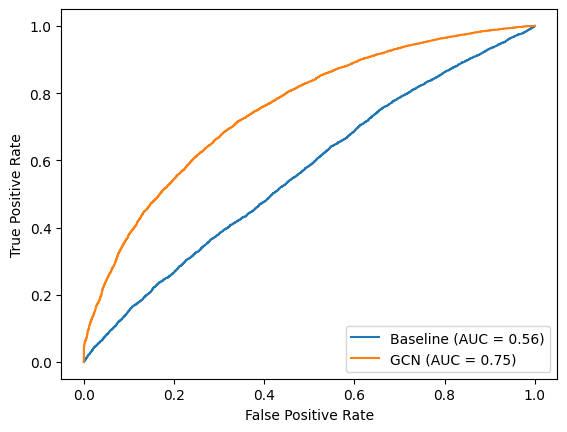

In [209]:
fpr, tpr, thresholds = roc_curve(y_all, y_probas_all_baseline)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Baseline')
display.plot()

ax = display.ax_

fpr, tpr, thresholds = roc_curve(y_all, y_preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='GCN')
display.plot(ax)

plt.show()

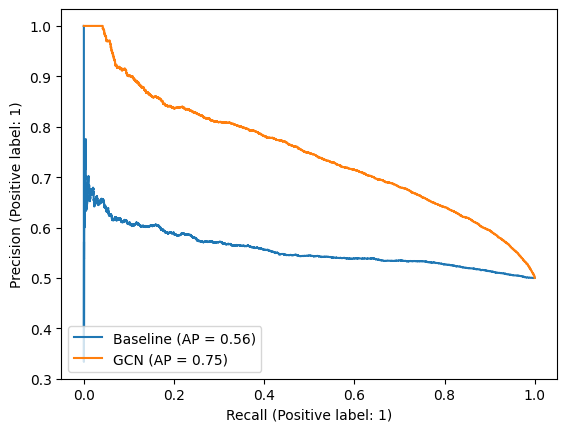

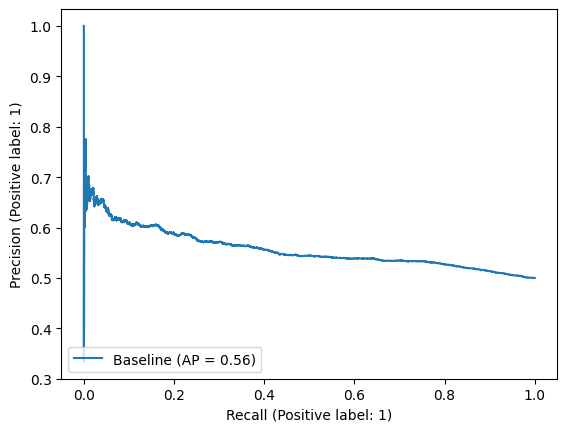

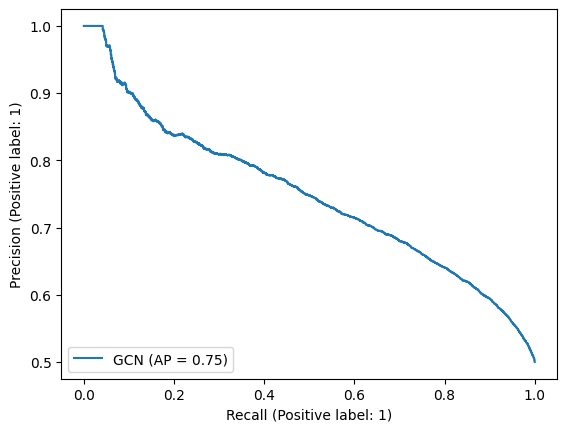

In [210]:
ax = plt.axes()

display = PrecisionRecallDisplay.from_predictions(y_all, y_probas_all_baseline, name="Baseline", pos_label=1)
display.plot(ax)

#ax = display.ax_

display = PrecisionRecallDisplay.from_predictions(y_all, y_preds, name="GCN", pos_label=1)
display.plot(ax)

#plt.show()

<Axes: >

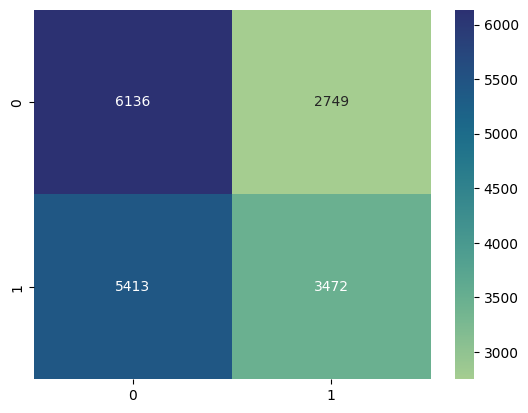

In [211]:
conf_mat = confusion_matrix(y_all, y_probas_all_baseline.round())
sns.heatmap(conf_mat, annot=True, cmap="crest", fmt=".0f")

<Axes: >

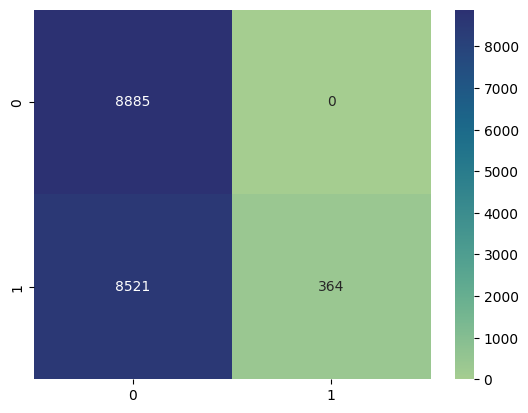

In [212]:
conf_mat = confusion_matrix(y_all, y_preds.round())
sns.heatmap(conf_mat, annot=True, cmap="crest", fmt=".0f")

In [213]:
print(classification_report(y_all, y_probas_all_baseline.round(), target_names=("edge", "negative edge")))
print(classification_report(y_all, y_preds.round(), target_names=("edge", "negative edge")))

               precision    recall  f1-score   support

         edge       0.53      0.69      0.60      8885
negative edge       0.56      0.39      0.46      8885

     accuracy                           0.54     17770
    macro avg       0.54      0.54      0.53     17770
 weighted avg       0.54      0.54      0.53     17770

               precision    recall  f1-score   support

         edge       0.51      1.00      0.68      8885
negative edge       1.00      0.04      0.08      8885

     accuracy                           0.52     17770
    macro avg       0.76      0.52      0.38     17770
 weighted avg       0.76      0.52      0.38     17770



# Running pipeline on multiple datasets

In [223]:
models = []

split_datasets = []

datasets = [facebook_dataset_basic, facebook_dataset_pca]

for dataset in datasets:
  print("----------")
  val_size = 0.1
  test_size = 0.2
  data = [a[0] for a in dataset]
  random.seed(43)
  random.shuffle(data)

  test_data = data[:int(test_size*len(data))]
  val_data = data[int(test_size*len(data)):int((test_size+val_size)*len(data))]
  train_data = data[int((test_size+val_size)*len(data)):]

  split_datasets.append((train_data, val_data, test_data))


  model = GCN(train_data[0].num_features, 256, 128, 128).to(device)
  train_model(model, train_data, val_data, 1000, 10, 50, "")

  models.append(model)

datasets = [gplus_dataset_diff,twitter_dataset_diff,twitter_dataset_cluster]

for dataset in datasets:
  print("----------")
  val_size = 0.1
  test_size = 0.2
  data = [a[0] for a in dataset]
  random.seed(43)
  random.shuffle(data)

  test_data = data[:int(test_size*len(data))]
  val_data = data[int(test_size*len(data)):int((test_size+val_size)*len(data))]
  train_data = data[int((test_size+val_size)*len(data)):]

  split_datasets.append((train_data, val_data, test_data))

  model = GCN(train_data[0].num_features, 256, 128, 128).to(device)
  train_model(model, train_data, val_data, 100, 5, 5, "")

  models.append(model)

----------
Epoch: 00, Train loss: 0.6932, Train acc 50.00%, Val loss: 0.6931, Val acc 50.00%
Epoch: 10, Train loss: 0.6327, Train acc 65.22%, Val loss: 0.6448, Val acc 63.71%
Epoch: 20, Train loss: 0.6546, Train acc 54.19%, Val loss: 0.6415, Val acc 67.71%
Epoch: 30, Train loss: 0.6706, Train acc 53.19%, Val loss: 0.6875, Val acc 51.17%
Epoch: 40, Train loss: 0.6585, Train acc 67.64%, Val loss: 0.6497, Val acc 72.54%
Epoch: 50, Train loss: 0.6217, Train acc 62.99%, Val loss: 0.6417, Val acc 72.54%
Epoch: 60, Train loss: 0.6732, Train acc 64.58%, Val loss: 0.6306, Val acc 66.78%
Epoch: 70, Train loss: 0.6274, Train acc 71.48%, Val loss: 0.6191, Val acc 74.39%
Epoch: 80, Train loss: 0.6140, Train acc 75.22%, Val loss: 0.6195, Val acc 74.73%
Epoch: 90, Train loss: 0.6097, Train acc 71.24%, Val loss: 0.6276, Val acc 74.78%
Epoch: 100, Train loss: 0.6145, Train acc 73.43%, Val loss: 0.6137, Val acc 73.51%
Epoch: 110, Train loss: 0.6180, Train acc 75.63%, Val loss: 0.6149, Val acc 74.63%
Epo

In [ ]:
names = ["FB Basic", "FB PCA", "G Diff", "T Diff", "T Cluster"]
ax = None
for model, (train_data, val_data, test_data), name in zip(models, split_datasets, names):
  y_all, y_probas_baseline = fit_predict_baseline(train_data, val_data, test_data)
  y_preds =  preds_from_model(model, test_data)

  fpr, tpr, thresholds = roc_curve(y_all, y_probas_all_baseline)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name + ' Baseline')
  if ax != None:
    display.plot(ax)
  else:
    display.plot(ax)

  if (ax==None):
    ax = display.ax_

  ax = display.ax_

  fpr, tpr, thresholds = roc_curve(y_all, y_preds)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name+' GCN')
  display.plot(ax)

plt.show()